In [96]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Impor the OpenWeatherMap API key
from api_key import key
from geoapi import geo_apikey

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy



: 

In [97]:
#https://api.census.gov/data/2019/acs/acs5?get=NAME,group(B01003)&for=city:*&key=YOUR_API_KEY

import requests
import json
# Set base URL
base_url = "https://api.census.gov/data"
year = '/2022'
data_name = '/acs/acs1/subject'
#all of the B02015 table ID data for all states
#qry = '?get=group(S1903)&for=place'
qry = "?get=NAME,S1903_C03_001E&for=place"
key = str('&key='+ key)

    # Make an API request using the params dictionary
test = str(base_url + year + data_name + qry + key)
test
response = requests.get(base_url + year + data_name + qry + key)
result = response.json()
print (json.dumps(result, indent=4))


[
    [
        "NAME",
        "S1903_C03_001E",
        "state",
        "place"
    ],
    [
        "Auburn city, Alabama",
        "54839",
        "01",
        "03076"
    ],
    [
        "Birmingham city, Alabama",
        "39326",
        "01",
        "07000"
    ],
    [
        "Dothan city, Alabama",
        "53929",
        "01",
        "21184"
    ],
    [
        "Hoover city, Alabama",
        "103194",
        "01",
        "35896"
    ],
    [
        "Huntsville city, Alabama",
        "68930",
        "01",
        "37000"
    ],
    [
        "Mobile city, Alabama",
        "50051",
        "01",
        "50000"
    ],
    [
        "Montgomery city, Alabama",
        "55108",
        "01",
        "51000"
    ],
    [
        "Tuscaloosa city, Alabama",
        "49005",
        "01",
        "77256"
    ],
    [
        "Anchorage municipality, Alaska",
        "100751",
        "02",
        "03000"
    ],
    [
        "Avondale city, Arizona",
        "66801

In [98]:
#https://www.pgpf.org/blog/2023/11/income-and-wealth-in-the-united-states-an-overview-of-recent-data#:~:text=According%20to%20the%20ASEC%2C%20median,the%20pandemic%20and%20subsequent%20recession.
median_income = 74580
# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Convert JSON data to DataFrame
    df = pd.DataFrame(data[1:], columns=data[0:])
    
    # Save the DataFrame to a CSV file
    df.to_csv("../data/census_data.csv", index=False)
    print("Data saved to census_data.csv")
else:
    print("Error:", response.status_code)

Data saved to census_data.csv


In [99]:
# Convert the cities weather data into a Pandas DataFrame
city_eco_data_df  = pd.read_csv('../data/census_data.csv')

# Splitting the 'NAME' column into two columns 'City' and 'State'
city_eco_data_df[['City', 'State']] = city_eco_data_df['NAME'].str.split(', ', expand=True)
#city_eco_data_df.drop(columns=['NAME'], inplace=True)

# Show Record Count
city_eco_data_df.count()
city_eco_data_df.head()

,NAME,S1903_C03_001E,state,place,City,State
0,"Auburn city, Alabama",54839,1,3076,Auburn city,Alabama
1,"Birmingham city, Alabama",39326,1,7000,Birmingham city,Alabama
2,"Dothan city, Alabama",53929,1,21184,Dothan city,Alabama
3,"Hoover city, Alabama",103194,1,35896,Hoover city,Alabama
4,"Huntsville city, Alabama",68930,1,37000,Huntsville city,Alabama


In [100]:
## splitting the eco median data into low income and high income..
city_eco_data_df = pd.DataFrame(city_eco_data_df)
city_eco_data_df = city_eco_data_df.drop_duplicates()
#city_eco_data_df = city_eco_data_df.drop_duplicates(subset=['City'])
# Splitting the DataFrame into two based on the condition
threshold_value = 74580
df_above_threshold = city_eco_data_df[city_eco_data_df['S1903_C03_001E'] > threshold_value]
df_below_threshold = city_eco_data_df[city_eco_data_df['S1903_C03_001E'] <= threshold_value]

len(city_eco_data_df), len(df_below_threshold), len(df_below_threshold)
#df_above_threshold, df_below_threshold


(646, 320, 320)

In [101]:
#the Geoapify Geocoding service URL for getting Coords for the City list extracted from the Census Data
def get_coordinates(city_name, geo_apikey):
    base_url = "https://api.geoapify.com/v1/geocode/search"
    params = {
        "text": city_name,
        "apiKey": geo_apikey
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data['features']:
            # Extracting the first result's coordinates
            coordinates = data['features'][0]['geometry']['coordinates']
            return coordinates
        else:
            return "No results found"
    else:
        return "Error in API request"

# pull the data
api_key = geo_apikey # Replace with your actual Geoapify API key
city_name1 = "New York"
coordinates = get_coordinates(city_name1, api_key)
print(f"Coordinates of {city_name1}: {coordinates}")

Coordinates of New York: [-74.0060152, 40.7127281]


In [102]:
# Path to the CSV file
coord_csv_file_path = "../data/city_coordinates.csv"

# Read and display the first few rows of the saved CSV file for verification
city_coordinates_df = pd.read_csv(coord_csv_file_path)
print(city_coordinates_df.head())

                       City   Latitude  Longitude
0      Auburn city, Alabama  32.601014 -85.516657
1  Birmingham city, Alabama  33.599853 -86.632216
2      Dothan city, Alabama  31.221808 -85.378001
3      Hoover city, Alabama  33.387197 -86.805680
4  Huntsville city, Alabama  34.729847 -86.585901


In [103]:
### process and compare a list of the eco data, and run it against the geoapify data.
## if the file already exists from a previous run...
## it will then check if the city has been extracted with coords from geoapify 

# Check if the CSV file already exists and read it, else create a new DataFrame
try:
    existing_data_df = city_coordinates_df
except FileNotFoundError:
    existing_data_df = pd.DataFrame(columns=['City', 'Latitude', 'Longitude'])

# Write headers to the CSV file if it's empty
if existing_data_df.empty:
    existing_data_df.to_csv(coord_csv_file_path, index=False)

# Iterating through the cities and fetching coordinates
for city in city_eco_data_df['NAME']:
    # Check if the city is already in the existing data
    if city not in existing_data_df['City'].values:
        coordinates = get_coordinates(city, api_key)
        if coordinates != [None, None]:
            # Creating a DataFrame for the current city
            temp_df = pd.DataFrame([{
                'City': city,
                'Latitude': coordinates[1],  # Latitude
                'Longitude': coordinates[0]  # Longitude
            }])
            
            # Append the current city's data to the CSV file
            temp_df.to_csv(coord_csv_file_path, mode='a', header=False, index=False)
            print(f"Getting data for {city}")
        else:
            print(f"Failed to fetch coordinates for {city}")
    else:
        print(f"{city} already exists in the dataset.")


Auburn city, Alabama already exists in the dataset.
Birmingham city, Alabama already exists in the dataset.
Dothan city, Alabama already exists in the dataset.
Hoover city, Alabama already exists in the dataset.
Huntsville city, Alabama already exists in the dataset.
Mobile city, Alabama already exists in the dataset.
Montgomery city, Alabama already exists in the dataset.
Tuscaloosa city, Alabama already exists in the dataset.
Anchorage municipality, Alaska already exists in the dataset.
Avondale city, Arizona already exists in the dataset.
Buckeye city, Arizona already exists in the dataset.
Casas Adobes CDP, Arizona already exists in the dataset.
Chandler city, Arizona already exists in the dataset.
Flagstaff city, Arizona already exists in the dataset.
Gilbert town, Arizona already exists in the dataset.
Glendale city, Arizona already exists in the dataset.
Goodyear city, Arizona already exists in the dataset.
Maricopa city, Arizona already exists in the dataset.
Mesa city, Arizona

In [104]:
# Read and display the first few rows of the saved CSV file for verification
city_coordinates_df = pd.read_csv(coord_csv_file_path)
city_coordinates_df = city_coordinates_df.drop_duplicates()
print(city_coordinates_df.head())

                       City   Latitude  Longitude
0      Auburn city, Alabama  32.601014 -85.516657
1  Birmingham city, Alabama  33.599853 -86.632216
2      Dothan city, Alabama  31.221808 -85.378001
3      Hoover city, Alabama  33.387197 -86.805680
4  Huntsville city, Alabama  34.729847 -86.585901


In [105]:
#verify data frame record counts
print(str(len(city_coordinates_df)) + ' compared to the source list length of: ' + str(len(city_eco_data_df)))


646 compared to the source list length of: 646


In [111]:
# using the csv previously created on first run to save time during testing/processing this code
# if this is the first time running, create a blank csv in the location listed below, with the name as shown.
high_inc_merged_df = pd.read_csv("../data/high_inc_data.csv")
low_inc_merged_df = pd.read_csv("../data/low_inc_data.csv")
df_above_threshold.columns
high_inc_merged_df.columns

Index(['NAME', 'High_med_inc', 'state', 'place', 'City_x', 'State', 'City_y',
       'Latitude', 'Longitude', 'Store Count', 'Store Coordinates',
       'Closest Store Distance', 'Furthest Store Distance',
       'Closest Store Coordinates', 'Furthest Store Coordinates'],
      dtype='object')

In [115]:
# Join the median range above/below threshold DFs to the Coords city DataFrames on the city names
# Check if the merge has already been done for high income dataframe
if 'City_x' not in high_inc_merged_df.columns:
    high_inc_merged_df = df_above_threshold.merge(city_coordinates_df, left_on='NAME', right_on='City')
    high_inc_merged_df = high_inc_merged_df.rename(columns={'S1903_C03_001E': 'High_med_inc'})
else:
    high_inc_merged_df = high_inc_merged_df

# Check if the merge has already been done for low income dataframe
if 'City_x' not in low_inc_merged_df.columns:
    low_inc_merged_df = df_below_threshold.merge(city_coordinates_df, left_on='NAME', right_on='City')
    low_inc_merged_df = low_inc_merged_df.rename(columns={'S1903_C03_001E': 'Low_med_inc'})
else:
    low_inc_merged_df = low_inc_merged_df

high_inc_merged_df, low_inc_merged_df

(                               NAME  High_med_inc  state  place  \
 0              Hoover city, Alabama        103194      1  35896   
 1    Anchorage municipality, Alaska        100751      2   3000   
 2             Buckeye city, Arizona         95235      4   7940   
 3         Casas Adobes CDP, Arizona         75650      4  10670   
 4            Chandler city, Arizona         98664      4  12000   
 ..                              ...           ...    ...    ...   
 321      South Hill CDP, Washington        109848     53  65922   
 322         Tacoma city, Washington         80784     53  70000   
 323      Vancouver city, Washington         76799     53  74060   
 324        Appleton city, Wisconsin         75262     55   2375   
 325        Waukesha city, Wisconsin         74675     55  84250   
 
                      City_x       State                          City_y  \
 0               Hoover city     Alabama            Hoover city, Alabama   
 1    Anchorage municipality  

In [117]:
#Adding store count and the store location coords based off category store type search to Geoapify places search
import requests

def add_store_count_to_df(df, geoapifykey):
    radius = 10000  # 10 kilometers
    categories = "commercial.weapons"
    print("Starting commercial weapons store search")

    for index, row in df.iterrows():
        lat, lon = row['Latitude'], row['Longitude']

        params = {
            "apiKey": geoapifykey,
            "categories": categories,
            "filter": f"circle:{lon},{lat},{radius}",
            "bias": f"proximity:{lon},{lat}"
        }

        base_url = "https://api.geoapify.com/v2/places"
        response = requests.get(base_url, params=params)
        stores = response.json()

        try:
            store_count = len(stores["features"])
            df.loc[index, "Store Count"] = store_count
            store_coordinates = []
            for feature in stores.get("features", []):
                coordinates = feature["geometry"]["coordinates"]
                store_coordinates.append(coordinates)
            df.loc[index, "Store Coordinates"] = str(store_coordinates)
        except (KeyError, IndexError):
            df.loc[index, "Store Count"] = 0
            df.loc[index, "Store Coordinates"] = str([])

        print(f"{row['NAME']} - Number of stores found: {store_count}")

# Replace 'geo_apikey' with your actual Geoapify API key
geoapifykey = geo_apikey

if 'Store Count' not in high_inc_merged_df.columns:
    add_store_count_to_df(high_inc_merged_df, geo_apikey)

if 'Store Count' not in low_inc_merged_df.columns:
    add_store_count_to_df(low_inc_merged_df, geo_apikey)

In [118]:
low_inc_merged_df

,Unnamed: 0,NAME,Low_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,Store Count,Store Coordinates,Closest Store Distance,Furthest Store Distance,Closest Store Coordinates,Furthest Store Coordinates
0,0,"Auburn city, Alabama",54839,1,3076,Auburn city,Alabama,"Auburn city, Alabama",32.601014,-85.516657,0.0,[],inf,0.000000,NaN,NaN
1,1,"Birmingham city, Alabama",39326,1,7000,Birmingham city,Alabama,"Birmingham city, Alabama",33.599853,-86.632216,1.0,"[[-86.58685474667458, 33.67531011917721]]",9.382680,9.382680,"[-86.58685474667458, 33.67531011917721]","[-86.58685474667458, 33.67531011917721]"
2,2,"Dothan city, Alabama",53929,1,21184,Dothan city,Alabama,"Dothan city, Alabama",31.221808,-85.378001,0.0,[],inf,0.000000,NaN,NaN
3,3,"Huntsville city, Alabama",68930,1,37000,Huntsville city,Alabama,"Huntsville city, Alabama",34.729847,-86.585901,0.0,[],inf,0.000000,NaN,NaN
4,4,"Mobile city, Alabama",50051,1,50000,Mobile city,Alabama,"Mobile city, Alabama",30.689362,-88.051896,0.0,[],inf,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,315,"Caguas zona urbana, Puerto Rico",22060,72,10334,Caguas zona urbana,Puerto Rico,"Caguas zona urbana, Puerto Rico",18.338810,-67.251630,0.0,[],inf,0.000000,NaN,NaN
316,316,"Carolina zona urbana, Puerto Rico",36646,72,14290,Carolina zona urbana,Puerto Rico,"Carolina zona urbana, Puerto Rico",18.407670,-65.981020,2.0,"[[-65.91480095515452, 18.376157378655126], [-6...",7.816525,9.866744,"[-65.91480095515452, 18.376157378655126]","[-66.06525819999999, 18.369150400265987]"
317,317,"Guaynabo zona urbana, Puerto Rico",48081,72,32522,Guaynabo zona urbana,Puerto Rico,"Guaynabo zona urbana, Puerto Rico",18.380340,-67.188390,0.0,[],inf,0.000000,NaN,NaN
318,318,"Ponce zona urbana, Puerto Rico",16795,72,63820,Ponce zona urbana,Puerto Rico,"Ponce zona urbana, Puerto Rico",18.338810,-67.251630,0.0,[],inf,0.000000,NaN,NaN


In [119]:
#high_inc_merged_df.to_csv('../data/high_inc_data.csv', index=False)
high_inc_merged_df

,NAME,High_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,Store Count,Store Coordinates,Closest Store Distance,Furthest Store Distance,Closest Store Coordinates,Furthest Store Coordinates
0,"Hoover city, Alabama",103194,1,35896,Hoover city,Alabama,"Hoover city, Alabama",33.387197,-86.805680,1.0,"[[-86.80535900676557, 33.404339373956915]]",1.906345,1.906345,"[-86.80535900676557, 33.404339373956915]","[-86.80535900676557, 33.404339373956915]"
1,"Anchorage municipality, Alaska",100751,2,3000,Anchorage municipality,Alaska,"Anchorage municipality, Alaska",61.216313,-149.894852,1.0,"[[-149.90488980910047, 61.19327695751528]]",2.617293,2.617293,"[-149.90488980910047, 61.19327695751528]","[-149.90488980910047, 61.19327695751528]"
2,"Buckeye city, Arizona",95235,4,7940,Buckeye city,Arizona,"Buckeye city, Arizona",33.370320,-112.583776,0.0,[],inf,0.000000,NaN,NaN
3,"Casas Adobes CDP, Arizona",75650,4,10670,Casas Adobes CDP,Arizona,"Casas Adobes CDP, Arizona",32.340932,-111.010201,0.0,[],inf,0.000000,NaN,NaN
4,"Chandler city, Arizona",98664,4,12000,Chandler city,Arizona,"Chandler city, Arizona",33.306203,-111.841185,12.0,"[[-111.8002181, 33.28209729958798], [-111.8326...",4.656479,9.514170,"[-111.8002181, 33.28209729958798]","[-111.74001920444977, 33.31937658388268]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,"South Hill CDP, Washington",109848,53,65922,South Hill CDP,Washington,"South Hill CDP, Washington",47.120551,-122.283781,0.0,[],inf,0.000000,NaN,NaN
322,"Tacoma city, Washington",80784,53,70000,Tacoma city,Washington,"Tacoma city, Washington",47.282117,-122.479299,3.0,"[[-122.4336389, 47.24002220011081], [-122.4537...",5.812183,5.998289,"[-122.4336389, 47.24002220011081]","[-122.42860969999997, 47.240564900110684]"
323,"Vancouver city, Washington",76799,53,74060,Vancouver city,Washington,"Vancouver city, Washington",45.625378,-122.675514,1.0,"[[-122.67574, 45.6282637003962]]",0.321299,0.321299,"[-122.67574, 45.6282637003962]","[-122.67574, 45.6282637003962]"
324,"Appleton city, Wisconsin",75262,55,2375,Appleton city,Wisconsin,"Appleton city, Wisconsin",44.262263,-88.406913,1.0,"[[-88.48058668045962, 44.26705403222755]]",5.890746,5.890746,"[-88.48058668045962, 44.26705403222755]","[-88.48058668045962, 44.26705403222755]"


In [120]:
#Calculate distances to each store based from center city coords to store coords

from math import radians, cos, sin, asin, sqrt
import ast

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of earth in kilometers
    return c * r

def calculate_distances(df):
    if 'Closest Store Distance' not in df.columns and 'Furthest Store Distance' not in df.columns:
        for index, row in df.iterrows():
            poi_lat, poi_lon = row['Latitude'], row['Longitude']
            store_coordinates = ast.literal_eval(row['Store Coordinates'])

            closest_distance = float('inf')
            furthest_distance = 0
            closest_store = None
            furthest_store = None

            for coordinates in store_coordinates:
                store_lon, store_lat = coordinates
                distance = haversine(poi_lon, poi_lat, store_lon, store_lat)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_store = coordinates
                if distance > furthest_distance:
                    furthest_distance = distance
                    furthest_store = coordinates

            df.loc[index, 'Closest Store Distance'] = closest_distance
            df.loc[index, 'Furthest Store Distance'] = furthest_distance
            df.loc[index, 'Closest Store Coordinates'] = str(closest_store)
            df.loc[index, 'Furthest Store Coordinates'] = str(furthest_store)

            print(f"Row {index}: Closest Store is at {closest_store} with a distance of {closest_distance} km")
            print(f"Row {index}: Furthest Store is at {furthest_store} with a distance of {furthest_distance} km")

# Apply to high income and low income dataframes
calculate_distances(high_inc_merged_df)
calculate_distances(low_inc_merged_df)

In [121]:
#high_inc_merged_df.to_csv("../data/high_inc_data.csv", mode='w', header=True, index=False)
high_inc_merged_df.head()

,NAME,High_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,Store Count,Store Coordinates,Closest Store Distance,Furthest Store Distance,Closest Store Coordinates,Furthest Store Coordinates
0,"Hoover city, Alabama",103194,1,35896,Hoover city,Alabama,"Hoover city, Alabama",33.387197,-86.805680,1.0,"[[-86.80535900676557, 33.404339373956915]]",1.906345,1.906345,"[-86.80535900676557, 33.404339373956915]","[-86.80535900676557, 33.404339373956915]"
1,"Anchorage municipality, Alaska",100751,2,3000,Anchorage municipality,Alaska,"Anchorage municipality, Alaska",61.216313,-149.894852,1.0,"[[-149.90488980910047, 61.19327695751528]]",2.617293,2.617293,"[-149.90488980910047, 61.19327695751528]","[-149.90488980910047, 61.19327695751528]"
2,"Buckeye city, Arizona",95235,4,7940,Buckeye city,Arizona,"Buckeye city, Arizona",33.370320,-112.583776,0.0,[],inf,0.000000,NaN,NaN
3,"Casas Adobes CDP, Arizona",75650,4,10670,Casas Adobes CDP,Arizona,"Casas Adobes CDP, Arizona",32.340932,-111.010201,0.0,[],inf,0.000000,NaN,NaN
4,"Chandler city, Arizona",98664,4,12000,Chandler city,Arizona,"Chandler city, Arizona",33.306203,-111.841185,12.0,"[[-111.8002181, 33.28209729958798], [-111.8326...",4.656479,9.514170,"[-111.8002181, 33.28209729958798]","[-111.74001920444977, 33.31937658388268]"


In [122]:
low_inc_merged_df.head()

,Unnamed: 0,NAME,Low_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,Store Count,Store Coordinates,Closest Store Distance,Furthest Store Distance,Closest Store Coordinates,Furthest Store Coordinates
0,0,"Auburn city, Alabama",54839,1,3076,Auburn city,Alabama,"Auburn city, Alabama",32.601014,-85.516657,0.0,[],inf,0.00000,NaN,NaN
1,1,"Birmingham city, Alabama",39326,1,7000,Birmingham city,Alabama,"Birmingham city, Alabama",33.599853,-86.632216,1.0,"[[-86.58685474667458, 33.67531011917721]]",9.38268,9.38268,"[-86.58685474667458, 33.67531011917721]","[-86.58685474667458, 33.67531011917721]"
2,2,"Dothan city, Alabama",53929,1,21184,Dothan city,Alabama,"Dothan city, Alabama",31.221808,-85.378001,0.0,[],inf,0.00000,NaN,NaN
3,3,"Huntsville city, Alabama",68930,1,37000,Huntsville city,Alabama,"Huntsville city, Alabama",34.729847,-86.585901,0.0,[],inf,0.00000,NaN,NaN
4,4,"Mobile city, Alabama",50051,1,50000,Mobile city,Alabama,"Mobile city, Alabama",30.689362,-88.051896,0.0,[],inf,0.00000,NaN,NaN


In [123]:
# Cleaning data frame from unusable values of NaN/Inf.. May consider different store type to have cleaner data
# but lets pretend no weapons = not legally allowed, so should not be analyzed

# Remove NaN values
high_inc_merged_clean_df = high_inc_merged_df.dropna()
low_inc_merged_clean_df = low_inc_merged_df.dropna()

# Replace infinite values with NaN
high_inc_merged_clean_df.replace([np.inf, -np.inf], np.nan, inplace=True)
low_inc_merged_clean_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN (which now includes the former infinite values)
high_inc_merged_clean_df.dropna(inplace=True)
low_inc_merged_clean_df.dropna(inplace=True)

high_inc_merged_clean_df

C:\Users\user\AppData\Local\Temp\ipykernel_14416\2590794151.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_inc_merged_clean_df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_14416\2590794151.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_inc_merged_clean_df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_14416\2590794151.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

,NAME,High_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,Store Count,Store Coordinates,Closest Store Distance,Furthest Store Distance,Closest Store Coordinates,Furthest Store Coordinates
0,"Hoover city, Alabama",103194,1,35896,Hoover city,Alabama,"Hoover city, Alabama",33.387197,-86.805680,1.0,"[[-86.80535900676557, 33.404339373956915]]",1.906345,1.906345,"[-86.80535900676557, 33.404339373956915]","[-86.80535900676557, 33.404339373956915]"
1,"Anchorage municipality, Alaska",100751,2,3000,Anchorage municipality,Alaska,"Anchorage municipality, Alaska",61.216313,-149.894852,1.0,"[[-149.90488980910047, 61.19327695751528]]",2.617293,2.617293,"[-149.90488980910047, 61.19327695751528]","[-149.90488980910047, 61.19327695751528]"
4,"Chandler city, Arizona",98664,4,12000,Chandler city,Arizona,"Chandler city, Arizona",33.306203,-111.841185,12.0,"[[-111.8002181, 33.28209729958798], [-111.8326...",4.656479,9.514170,"[-111.8002181, 33.28209729958798]","[-111.74001920444977, 33.31937658388268]"
5,"Gilbert town, Arizona",111393,4,27400,Gilbert town,Arizona,"Gilbert town, Arizona",33.352763,-111.789037,20.0,"[[-111.82742529999999, 33.3526513995885], [-11...",3.565578,7.780236,"[-111.82742529999999, 33.3526513995885]","[-111.79920625671382, 33.42221543011732]"
8,"Mesa city, Arizona",79496,4,46000,Mesa city,Arizona,"Mesa city, Arizona",33.415101,-111.831455,20.0,"[[-111.82256429999995, 33.40832429958904], [-1...",1.117461,8.188997,"[-111.82256429999995, 33.40832429958904]","[-111.90720999119976, 33.37737105117534]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,"Renton city, Washington",93388,53,57745,Renton city,Washington,"Renton city, Washington",47.479908,-122.203450,1.0,"[[-122.1948545, 47.533885400046024]]",6.036657,6.036657,"[-122.1948545, 47.533885400046024]","[-122.1948545, 47.533885400046024]"
319,"Sammamish city, Washington",223849,53,61115,Sammamish city,Washington,"Sammamish city, Washington",47.601755,-122.041684,2.0,"[[-122.1596282226403, 47.623847352257506], [-1...",9.176072,9.344658,"[-122.1596282226403, 47.623847352257506]","[-122.16022170000001, 47.627780000024714]"
322,"Tacoma city, Washington",80784,53,70000,Tacoma city,Washington,"Tacoma city, Washington",47.282117,-122.479299,3.0,"[[-122.4336389, 47.24002220011081], [-122.4537...",5.812183,5.998289,"[-122.4336389, 47.24002220011081]","[-122.42860969999997, 47.240564900110684]"
323,"Vancouver city, Washington",76799,53,74060,Vancouver city,Washington,"Vancouver city, Washington",45.625378,-122.675514,1.0,"[[-122.67574, 45.6282637003962]]",0.321299,0.321299,"[-122.67574, 45.6282637003962]","[-122.67574, 45.6282637003962]"


In [124]:
low_inc_merged_clean_df

,Unnamed: 0,NAME,Low_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,Store Count,Store Coordinates,Closest Store Distance,Furthest Store Distance,Closest Store Coordinates,Furthest Store Coordinates
1,1,"Birmingham city, Alabama",39326,1,7000,Birmingham city,Alabama,"Birmingham city, Alabama",33.599853,-86.632216,1.0,"[[-86.58685474667458, 33.67531011917721]]",9.382680,9.382680,"[-86.58685474667458, 33.67531011917721]","[-86.58685474667458, 33.67531011917721]"
8,8,"Flagstaff city, Arizona",63612,4,23620,Flagstaff city,Arizona,"Flagstaff city, Arizona",35.238626,-111.663258,1.0,"[[-111.66694339999998, 35.177647199664186]]",6.788771,6.788771,"[-111.66694339999998, 35.177647199664186]","[-111.66694339999998, 35.177647199664186]"
9,9,"Glendale city, Arizona",72411,4,27820,Glendale city,Arizona,"Glendale city, Arizona",33.538686,-112.185994,4.0,"[[-112.20366784107148, 33.53803469609104], [-1...",1.639660,9.171527,"[-112.20366784107148, 33.53803469609104]","[-112.2574001, 33.595809899591686]"
11,11,"Yuma city, Arizona",58043,4,85540,Yuma city,Arizona,"Yuma city, Arizona",33.435138,-112.075119,1.0,"[[-112.05683349999998, 33.49541119959011]]",6.913430,6.913430,"[-112.05683349999998, 33.49541119959011]","[-112.05683349999998, 33.49541119959011]"
14,14,"Fort Smith city, Arkansas",47669,5,24550,Fort Smith city,Arkansas,"Fort Smith city, Arkansas",35.384996,-94.425305,1.0,"[[-94.42170018169259, 35.38447196173662]]",0.331946,0.331946,"[-94.42170018169259, 35.38447196173662]","[-94.42170018169259, 35.38447196173662]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,303,"Spokane Valley city, Washington",66484,53,67167,Spokane Valley city,Washington,"Spokane Valley city, Washington",47.656552,-117.267696,3.0,"[[-117.3241651, 47.661961200016876], [-117.359...",4.271737,7.410638,"[-117.3241651, 47.661961200016876]","[-117.36422359999997, 47.671229700014734]"
304,304,"Yakima city, Washington",56821,53,80010,Yakima city,Washington,"Yakima city, Washington",46.618755,-120.578637,1.0,"[[-120.52978122545436, 46.643974956259086]]",4.666944,4.666944,"[-120.52978122545436, 46.643974956259086]","[-120.52978122545436, 46.643974956259086]"
313,313,"Cheyenne city, Wyoming",70597,56,13900,Cheyenne city,Wyoming,"Cheyenne city, Wyoming",41.118187,-104.769403,2.0,"[[-104.79350899999999, 41.129840000406396], [-...",2.399207,4.786724,"[-104.79350899999999, 41.129840000406396]","[-104.78012710033968, 41.160470234777556]"
314,314,"Bayamón zona urbana, Puerto Rico",28425,72,6593,Bayamón zona urbana,Puerto Rico,"Bayamón zona urbana, Puerto Rico",18.379290,-66.163520,1.0,"[[-66.1864101, 18.408926500269295]]",4.085724,4.085724,"[-66.1864101, 18.408926500269295]","[-66.1864101, 18.408926500269295]"


In [126]:
#take the average amount of store types per high income city
# Calculate the total store count
total_store_count_high = high_inc_merged_clean_df['Store Count'].sum()
total_store_count_low = low_inc_merged_clean_df['Store Count'].sum()
# Calculate the number of locations
number_of_locations_high = len(high_inc_merged_clean_df)
number_of_locations_low = len(low_inc_merged_clean_df)
# Calculate the average store count per location
average_store_count_high = total_store_count_high / number_of_locations_high
average_store_count_low = total_store_count_low / number_of_locations_low
print("Average Store Count per Location - high:", average_store_count_high)

print("Average Store Count per Location - low:", average_store_count_low)

Average Store Count per Location - high: 2.2440944881889764
Average Store Count per Location - low: 1.6923076923076923


In [132]:
import scipy.stats as st

# For high income dataframe
closest_distances_high = high_inc_merged_clean_df['Closest Store Distance']
high_med_inc = high_inc_merged_clean_df["High_med_inc"]
correlation_coefficient_high = st.pearsonr(high_med_inc, closest_distances_high)[0]
print(f"The correlation coefficient between higher income and distance to the closest store is {round(correlation_coefficient_high, 2)}")
print(f"The average minimum closest distance for high income cities is {closest_distances_high.mean()} km")

# For low income dataframe
closest_distances_low = low_inc_merged_clean_df['Closest Store Distance']
low_med_inc = low_inc_merged_clean_df["Low_med_inc"]
correlation_coefficient_low = st.pearsonr(low_med_inc, closest_distances_low)[0]
print(f"The correlation coefficient between lower income and distance to the closest store is {round(correlation_coefficient_low, 2)}")
print(f"The average minimum closest distance for low income cities is {closest_distances_low.mean()} km")

The correlation coefficient between higher income and distance to the closest store is 0.13
The average minimum closest distance for high income cities is 4.8823405687916726 km
The correlation coefficient between lower income and distance to the closest store is -0.02
The average minimum closest distance for low income cities is 5.508763764040769 km


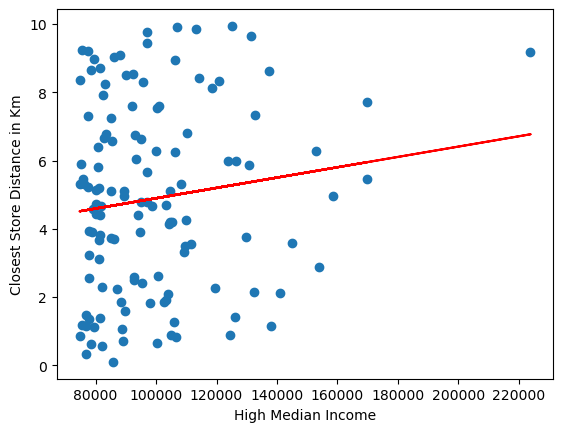

In [133]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = high_inc_merged_clean_df["High_med_inc"]
y_values = high_inc_merged_clean_df["Closest Store Distance"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('High Median Income')
plt.ylabel('Closest Store Distance in Km')
plt.show()

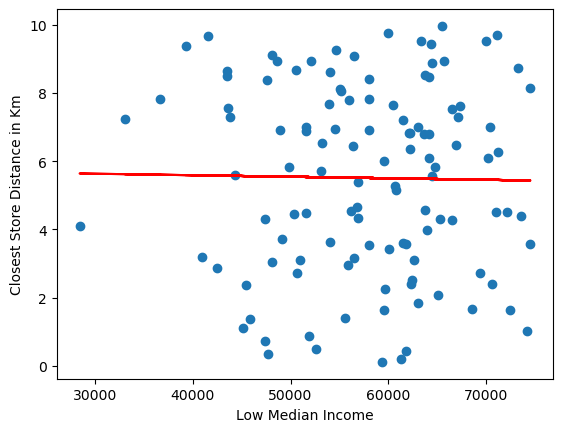

In [134]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = low_inc_merged_clean_df["Low_med_inc"]
y_values = low_inc_merged_clean_df["Closest Store Distance"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Low Median Income')
plt.ylabel('Closest Store Distance in Km')
plt.show()